# Data Cleaning and Prep 

In [51]:
import nltk
import matplotlib
import os
import glob
import nltk, re, pprint
import pandas as pd
from nltk import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer
import mpld3
import gensim 
import pyLDAvis.gensim
import numpy as np

In [52]:
# use glob to get all the files that end with .txt 
textFiles = glob.glob("Books/*txt")
textFiles
type(textFiles)

list

In [53]:
# transform into dictionary so I can have access to books
d = {}
for textFile in textFiles:
    d['f{0}'.format(textFile)] = open(textFile).read()
 
d.keys()

dict_keys(['fBooks/text_38.txt', 'fBooks/text_10.txt', 'fBooks/text_264.txt', 'fBooks/text_270.txt', 'fBooks/text_258.txt', 'fBooks/text_310.txt', 'fBooks/text_304.txt', 'fBooks/text_338.txt', 'fBooks/text_112.txt', 'fBooks/text_106.txt', 'fBooks/text_107.txt', 'fBooks/text_113.txt', 'fBooks/text_339.txt', 'fBooks/text_305.txt', 'fBooks/text_311.txt', 'fBooks/text_259.txt', 'fBooks/text_271.txt', 'fBooks/text_265.txt', 'fBooks/text_11.txt', 'fBooks/text_39.txt', 'fBooks/text_13.txt', 'fBooks/text_273.txt', 'fBooks/text_267.txt', 'fBooks/text_298.txt', 'fBooks/text_307.txt', 'fBooks/text_313.txt', 'fBooks/text_105.txt', 'fBooks/text_111.txt', 'fBooks/text_139.txt', 'fBooks/text_138.txt', 'fBooks/text_110.txt', 'fBooks/text_104.txt', 'fBooks/text_312.txt', 'fBooks/text_306.txt', 'fBooks/text_299.txt', 'fBooks/text_266.txt', 'fBooks/text_272.txt', 'fBooks/text_12.txt', 'fBooks/text_16.txt', 'fBooks/text_276.txt', 'fBooks/text_262.txt', 'fBooks/text_289.txt', 'fBooks/text_302.txt', 'fBooks

In [54]:
# convert the book titles into a list
book_titles = list(d.keys())

# convert values into a list
book_text = list(d.values())

# see first items 
book_text[338][:100]

'Begin Reading\n\nTable of Contents\n\nAbout the Author\n\nCopyright Page\n\n\n\nThank you for buying this\n\nSt.'

In [55]:
# transform book titles into a book array to add as a column to a df later
book_array = np.asarray(book_titles)
type(book_array)

numpy.ndarray

## Stopwords, stemming, lemmatizing, and tokenizing 

This section is focused on defining some functions to manipulate the synopses. First, I load NLTK's list of English stop words. Stop words are words like "a", "the", or "in" which don't convey significant meaning. I also append 'towards' as a stopwords, since it appeared as a high frequency item and had to account for spelling (toward vs towards), and 'Chapter'

In [56]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# add towards to the list of stop words 
stopwords.append(['towards', 'Chapter', 'chapter'])

# check the stopwpords were added 
stopwords[-1]

['towards', 'Chapter', 'chapter']

Next I import the Snowball Stemmer and Lemmatizer to get to the root of the word or root meaning.

In [57]:
# load nltk's SnowballStemmer as variable 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# import WordNetLemmatizer as variable 'lemmatizer'
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

Below I define three functions:

* tokenize_and_stem: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token
* tokenize_and_lemmatize: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also lemmatizes each token
* tokenize_only: tokenizes the synopsis only

In [58]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


def tokenize_and_lemmatize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lems = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lems

In [59]:
from nltk.tag import pos_tag

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
def strip_proppers_POS(text):
    tagged = pos_tag(text) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if word.islower() and word.isalpha() and pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

# Filter for only nouns
def noun_only(text):
    pos_comment = nltk.pos_tag(text)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

Here I run the actual text processing (removing of proper nouns, tokenization, removal of stop words)

In [60]:
from gensim import corpora, models, similarities 

#tokenize and lemmatize 
%time tokenized_text = [tokenize_and_lemmatize(text) for text in book_text]

#remove stop words
%time preprocess = [[word for word in text if word not in stopwords] for text in tokenized_text]

# remove proper nouns
%time texts = [strip_proppers_POS(doc) for doc in preprocess]

CPU times: user 9min 27s, sys: 8.44 s, total: 9min 35s
Wall time: 9min 49s
CPU times: user 52.8 s, sys: 2.17 s, total: 55 s
Wall time: 55.6 s
CPU times: user 19min 21s, sys: 12.6 s, total: 19min 34s
Wall time: 21min 8s


# Latent Diriechlet Allocation Models

## Latent Dirichlet Allocation¶

This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the 339 romance novels books. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics.

I use Gensim's implementation, and need a dictionary and a corpus that uses bag of words. 

In [61]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

## LDA model: chunking 2000 and topics 25

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [62]:
# increase the topic number to 25
%time lda_mod25 = models.LdaModel(corpus, num_topics=25,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 43min 33s, sys: 23.5 s, total: 43min 57s
Wall time: 23min 18s


In [63]:
lda_mod25.show_topics(25, num_words = 50)

[(0,
  '0.003*"client" + 0.002*"sofa" + 0.002*"contract" + 0.002*"tea" + 0.002*"staff" + 0.002*"song" + 0.002*"elevator" + 0.002*"gestured" + 0.002*"stage" + 0.002*"piano" + 0.002*"student" + 0.002*"band" + 0.002*"text" + 0.001*"lobby" + 0.001*"article" + 0.001*"tie" + 0.001*"design" + 0.001*"computer" + 0.001*"board" + 0.001*"bank" + 0.001*"bench" + 0.001*"sport" + 0.001*"art" + 0.001*"seated" + 0.001*"practice" + 0.001*"mug" + 0.001*"fingertip" + 0.001*"project" + 0.001*"club" + 0.001*"television" + 0.001*"strode" + 0.001*"swung" + 0.001*"agent" + 0.001*"security" + 0.001*"interview" + 0.001*"island" + 0.001*"assistant" + 0.001*"player" + 0.001*"jazz" + 0.001*"flight" + 0.001*"chuckle" + 0.001*"winked" + 0.001*"parking" + 0.001*"partner" + 0.001*"studio" + 0.001*"artist" + 0.001*"menu" + 0.001*"professional" + 0.001*"rising" + 0.001*"draped"'),
 (1,
  '0.011*"church" + 0.009*"mill" + 0.004*"farm" + 0.004*"sir" + 0.004*"revival" + 0.003*"bride" + 0.003*"fixed" + 0.003*"train" + 0.003*

In [64]:
# Compute Perplexity
print('Perplexity: ', lda_mod25.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod25, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.266625893901853
Coherence score:  0.4436721157065622


# Topic Matrices

### Model with 25 topics

In [65]:
topics_matrix = lda_mod25.show_topics(formatted=False, num_words=30)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

["('client', 0.002783588)", "('sofa', 0.002381166)", "('contract', 0.0022392382)", "('tea', 0.0021651813)", "('staff', 0.002129016)", "('song', 0.0020941517)", "('elevator', 0.0018246986)", "('gestured', 0.0018157939)", "('stage', 0.0018116719)", "('piano', 0.0016123329)", "('student', 0.0015455226)", "('band', 0.0015106724)", "('text', 0.0015098143)", "('lobby', 0.0014315458)", "('article', 0.0014161147)", "('tie', 0.0013737489)", "('design', 0.0013643223)", "('computer', 0.0013513179)", "('board', 0.0013447301)", "('bank', 0.0013324729)", "('bench', 0.0013158765)", "('sport', 0.0012823445)", "('art', 0.0012680191)", "('seated', 0.0012618961)", "('practice', 0.0012365868)", "('mug', 0.0012349808)", "('fingertip', 0.0012053741)", "('project', 0.0012030825)", "('club', 0.0011939133)", "('television', 0.0011786364)"]

["('realised', 0.0037291688)", "('prince', 0.0026798393)", "('towards', 0.0026159072)", "('perhaps', 0.0022109903)", "('murmured', 0.002053098)", "('palace', 0.0018200445)"

# Heatmap comparing book topics

Source/inspo: https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb

In [66]:
# get topics for every book 
topics = [lda_mod25[corpus[i]] for i in range(len(book_text))]

# define function to get the topics into a df 
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(25))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

# test function 
topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,...,0.0913012,NaN,NaN,0.869287,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=25) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

document_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.013124,0.0,0.147599,0.000000,0,0.000000,0.000000,0,0,0.0,...,0.323032,0.0,0.0,0.000000,0.0,0,0.000000,0.0,0.000000,0.000000
1,0.000000,0.0,0.486834,0.000000,0,0.034283,0.032605,0,0,0.0,...,0.016554,0.0,0.0,0.337007,0.0,0,0.000000,0.0,0.000000,0.052568
2,0.000000,0.0,0.392388,0.041853,0,0.000000,0.000000,0,0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0,0.000000,0.0,0.462927,0.096210
3,0.000000,0.0,0.027538,0.000000,0,0.010778,0.000000,0,0,0.0,...,0.089527,0.0,0.0,0.000000,0.0,0,0.000000,0.0,0.045953,0.000000
4,0.090681,0.0,0.441143,0.221462,0,0.000000,0.000000,0,0,0.0,...,0.021930,0.0,0.0,0.052019,0.0,0,0.015846,0.0,0.127743,0.000000


### Visualize the topics in each book

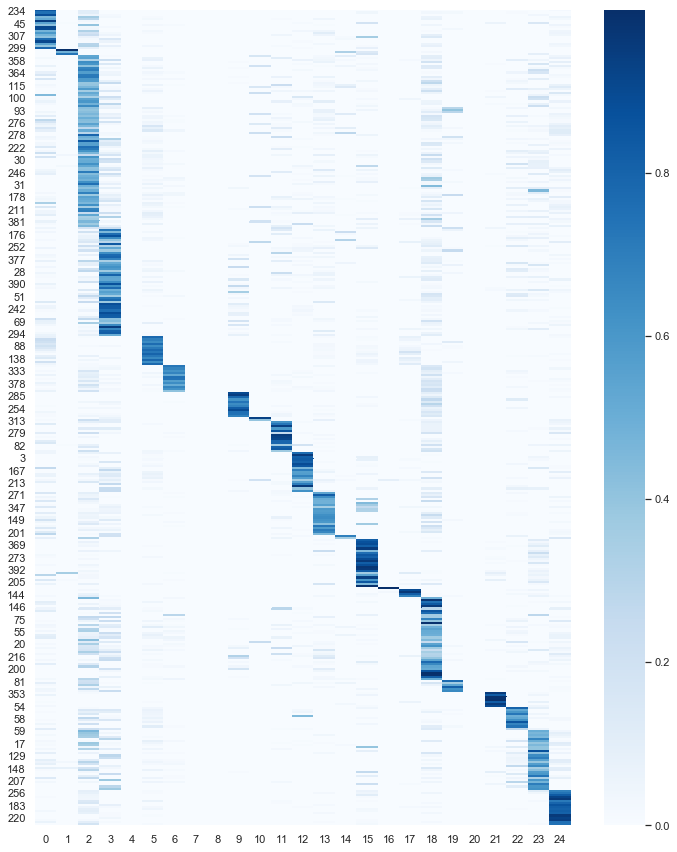

In [68]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(12,15)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index], cmap = 'Blues')

In [69]:
document_topic2 = document_topic

# Combine topic data to book meta data

In [70]:
# define function to get the numbers from rows with strings 
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

In [71]:
document_topic['standard_title'] = book_array

document_topic['book_title_number'] = document_topic['standard_title'].apply(lambda x: find_number(x))

document_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,standard_title,book_title_number
0,0.013124,0.0,0.147599,0.000000,0,0.000000,0.000000,0,0,0.0,...,0.0,0.000000,0.0,0,0.000000,0.0,0.000000,0.000000,fBooks/text_38.txt,38
1,0.000000,0.0,0.486834,0.000000,0,0.034283,0.032605,0,0,0.0,...,0.0,0.337007,0.0,0,0.000000,0.0,0.000000,0.052568,fBooks/text_10.txt,10
2,0.000000,0.0,0.392388,0.041853,0,0.000000,0.000000,0,0,0.0,...,0.0,0.000000,0.0,0,0.000000,0.0,0.462927,0.096210,fBooks/text_264.txt,264
3,0.000000,0.0,0.027538,0.000000,0,0.010778,0.000000,0,0,0.0,...,0.0,0.000000,0.0,0,0.000000,0.0,0.045953,0.000000,fBooks/text_270.txt,270
4,0.090681,0.0,0.441143,0.221462,0,0.000000,0.000000,0,0,0.0,...,0.0,0.052019,0.0,0,0.015846,0.0,0.127743,0.000000,fBooks/text_258.txt,258


In [73]:
# read csv file with the book metadata 
book_metadata = pd.read_csv('List of Books and Authors - metadata.csv')

#book_metadata = book_metadata.set_index('file_number')

book_metadata['book_title_number'] = book_metadata['file_number'].apply(str)

book_metadata.head()

,Author,Book,Image,Year,Description,Buy,Book_old,file_number,book_title_number
0,Adriana Herrera,American Dreamer,https://images-na.ssl-images-amazon.com/images...,2020,No one ever said big dreams come easy\n\nFor N...,https://www.amazon.com/American-Dreamer-Dreame...,American dreamer,221,221
1,Adriana Herrera,American Love Story,https://m.media-amazon.com/images/I/41AY3Khzbl...,2019,No one should have to choose between love and ...,https://www.amazon.com/American-Love-Story-Dre...,American love story,222,222
2,Adriana Herrera,American Sweetheart,https://m.media-amazon.com/images/I/51RJdJyI+t...,2020,Juan Pablo Campos doesn't do regrets. He's liv...,https://www.amazon.com/American-Sweethearts-Dr...,American sweetheart,223,223
3,Adriana Herrera,Finding Joy,https://m.media-amazon.com/images/I/416M8GuOj3...,2020,"As his twenty-sixth birthday approaches, Desta...",https://www.amazon.com/Finding-Joy-Romance-Adr...,Finding joy,224,224
4,Adriana Herrera,Here to Stay,https://m.media-amazon.com/images/I/51ZN1hKljE...,2020,Starting over is more about who you're with th...,https://www.amazon.com/Here-Stay-Adriana-Herre...,Here to stay,225,225


In [74]:
book_df = document_topic.merge(book_metadata, how='outer', right_on = 'book_title_number', left_on = 'book_title_number')

book_df = book_df.set_index('Book')

book_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,standard_title,book_title_number,Author,Image,Year,Description,Buy,Book_old,file_number
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a New Day,0.013124,0.0,0.147599,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,fBooks/text_38.txt,38,Beverly Jenkins,https://i.imgur.com/AJuixZy.jpg,2016.0,"In Henry Adams, Kansas, you can't start over w...",https://www.goodreads.com/book/show/27064404-s...,Stepping to a new day,38.0
Her Lover's Legacy,0.000000,0.0,0.486834,0.000000,0.0,0.034283,0.032605,0.0,0.0,0.0,...,0.052568,fBooks/text_10.txt,10,Adrianne Byrd,https://m.media-amazon.com/images/I/51QRhQpBff...,2008.0,Heir-apparent Malcolm Braddock may be the sexi...,https://www.amazon.com/gp/product/0373860765/r...,Her lovers legacy,10.0
Island Fling with the Tycoon,0.000000,0.0,0.392388,0.041853,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.096210,fBooks/text_264.txt,264,Therese Beharrie,https://m.media-amazon.com/images/I/51Cqm0Ppgn...,2019.0,Could a fairytale weddindlead to her own love ...,https://www.amazon.com/Island-Fling-Tycoon-Har...,Island fling,264.0
The Kingmaker,0.000000,0.0,0.027538,0.000000,0.0,0.010778,0.000000,0.0,0.0,0.0,...,0.000000,fBooks/text_270.txt,270,Kennedy Ryan,https://i.imgur.com/WgtINQb.jpg,2019.0,"Power. Passion. Betrayal. Raised to rule, bred...",https://www.amazon.com/Kingmaker-All-Kings-Due...,The kingmaker,270.0
The Write Escape: An Irish Romance,0.090681,0.0,0.441143,0.221462,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,fBooks/text_258.txt,258,Charish Reid,https://m.media-amazon.com/images/I/419e+vtoBX...,2019.0,Take one heartbroken Chicago girl\n\nLiterary ...,https://www.amazon.com/Write-Escape-Charish-Re...,The write escape,258.0


In [75]:
book_viz = book_df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                    22, 23, 24, 'Author', 'Image', 'Year', 'Description', 'Buy']]

book_viz

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,Author,Image,Year,Description,Buy
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a New Day,0.013124,0.00000,0.147599,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,Beverly Jenkins,https://i.imgur.com/AJuixZy.jpg,2016.0,"In Henry Adams, Kansas, you can't start over w...",https://www.goodreads.com/book/show/27064404-s...
Her Lover's Legacy,0.000000,0.00000,0.486834,0.000000,0.0,0.034283,0.032605,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.052568,Adrianne Byrd,https://m.media-amazon.com/images/I/51QRhQpBff...,2008.0,Heir-apparent Malcolm Braddock may be the sexi...,https://www.amazon.com/gp/product/0373860765/r...
Island Fling with the Tycoon,0.000000,0.00000,0.392388,0.041853,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.462927,0.096210,Therese Beharrie,https://m.media-amazon.com/images/I/51Cqm0Ppgn...,2019.0,Could a fairytale weddindlead to her own love ...,https://www.amazon.com/Island-Fling-Tycoon-Har...
The Kingmaker,0.000000,0.00000,0.027538,0.000000,0.0,0.010778,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.045953,0.000000,Kennedy Ryan,https://i.imgur.com/WgtINQb.jpg,2019.0,"Power. Passion. Betrayal. Raised to rule, bred...",https://www.amazon.com/Kingmaker-All-Kings-Due...
The Write Escape: An Irish Romance,0.090681,0.00000,0.441143,0.221462,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.015846,0.000000,0.127743,0.000000,Charish Reid,https://m.media-amazon.com/images/I/419e+vtoBX...,2019.0,Take one heartbroken Chicago girl\n\nLiterary ...,https://www.amazon.com/Write-Escape-Charish-Re...
Higher Love,0.063892,0.00000,0.086830,0.504906,0.0,0.012902,0.000000,0.0,0.0,0.080618,...,0.0,0.000000,0.000000,0.000000,0.028394,Alexandria House,https://m.media-amazon.com/images/I/515nkoL5MK...,2016.0,"Popular travel blogger, Greer Kennedy, is livi...",https://www.amazon.com/Higher-Love-After-Book-...
Go Deep,0.000000,0.00000,0.090030,0.512022,0.0,0.000000,0.000000,0.0,0.0,0.030654,...,0.0,0.000000,0.127259,0.038546,0.000000,Rilzy Adams,https://m.media-amazon.com/images/I/41wKLNq64-...,2020.0,It was all supposed to be so simple. Navaya Ho...,https://www.amazon.com/Go-Deep-Unexpected-Love...
The Sweetest Surrender,0.012558,0.00000,0.035164,0.030944,0.0,0.014306,0.618492,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.018707,Stephanie Nicole Norris,https://m.media-amazon.com/images/I/51oJyo3-Pb...,2018.0,"Effervescent, Fearless, and self-assured, Sele...",https://www.amazon.com/Sweetest-Surrender-Fall...
His Diamond Queen,0.000000,0.00000,0.415420,0.128756,0.0,0.076898,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.093808,0.085109,0.044686,Lena Hart,https://m.media-amazon.com/images/I/91E1aODCUc...,2014.0,"Loyalty comes at a cost. Former MMA fighter, J...",https://www.amazon.com/His-Diamond-Queen-Quart...


In [76]:
book_viz['max_val'] = book_viz[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                17, 18, 19, 20, 21,22, 23, 24]].max(axis=1)
book_viz['max_col'] = book_viz[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19, 20, 21, 22, 23, 24]].idxmax(axis=1)

#document_topic['second_largest'] = document_topic.apply(lambda row: row.nlargest(2).values[-1],axis=1)
book_viz

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,Author,Image,Year,Description,Buy,max_val,max_col
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a New Day,0.013124,0.00000,0.147599,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,Beverly Jenkins,https://i.imgur.com/AJuixZy.jpg,2016.0,"In Henry Adams, Kansas, you can't start over w...",https://www.goodreads.com/book/show/27064404-s...,0.505695,13.0
Her Lover's Legacy,0.000000,0.00000,0.486834,0.000000,0.0,0.034283,0.032605,0.0,0.0,0.000000,...,0.000000,0.000000,0.052568,Adrianne Byrd,https://m.media-amazon.com/images/I/51QRhQpBff...,2008.0,Heir-apparent Malcolm Braddock may be the sexi...,https://www.amazon.com/gp/product/0373860765/r...,0.486834,2.0
Island Fling with the Tycoon,0.000000,0.00000,0.392388,0.041853,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.462927,0.096210,Therese Beharrie,https://m.media-amazon.com/images/I/51Cqm0Ppgn...,2019.0,Could a fairytale weddindlead to her own love ...,https://www.amazon.com/Island-Fling-Tycoon-Har...,0.462927,23.0
The Kingmaker,0.000000,0.00000,0.027538,0.000000,0.0,0.010778,0.000000,0.0,0.0,0.000000,...,0.000000,0.045953,0.000000,Kennedy Ryan,https://i.imgur.com/WgtINQb.jpg,2019.0,"Power. Passion. Betrayal. Raised to rule, bred...",https://www.amazon.com/Kingmaker-All-Kings-Due...,0.816463,12.0
The Write Escape: An Irish Romance,0.090681,0.00000,0.441143,0.221462,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.127743,0.000000,Charish Reid,https://m.media-amazon.com/images/I/419e+vtoBX...,2019.0,Take one heartbroken Chicago girl\n\nLiterary ...,https://www.amazon.com/Write-Escape-Charish-Re...,0.441143,2.0
Higher Love,0.063892,0.00000,0.086830,0.504906,0.0,0.012902,0.000000,0.0,0.0,0.080618,...,0.000000,0.000000,0.028394,Alexandria House,https://m.media-amazon.com/images/I/515nkoL5MK...,2016.0,"Popular travel blogger, Greer Kennedy, is livi...",https://www.amazon.com/Higher-Love-After-Book-...,0.504906,3.0
Go Deep,0.000000,0.00000,0.090030,0.512022,0.0,0.000000,0.000000,0.0,0.0,0.030654,...,0.127259,0.038546,0.000000,Rilzy Adams,https://m.media-amazon.com/images/I/41wKLNq64-...,2020.0,It was all supposed to be so simple. Navaya Ho...,https://www.amazon.com/Go-Deep-Unexpected-Love...,0.512022,3.0
The Sweetest Surrender,0.012558,0.00000,0.035164,0.030944,0.0,0.014306,0.618492,0.0,0.0,0.000000,...,0.000000,0.000000,0.018707,Stephanie Nicole Norris,https://m.media-amazon.com/images/I/51oJyo3-Pb...,2018.0,"Effervescent, Fearless, and self-assured, Sele...",https://www.amazon.com/Sweetest-Surrender-Fall...,0.618492,6.0
His Diamond Queen,0.000000,0.00000,0.415420,0.128756,0.0,0.076898,0.000000,0.0,0.0,0.000000,...,0.093808,0.085109,0.044686,Lena Hart,https://m.media-amazon.com/images/I/91E1aODCUc...,2014.0,"Loyalty comes at a cost. Former MMA fighter, J...",https://www.amazon.com/His-Diamond-Queen-Quart...,0.415420,2.0


In [77]:
bookData = book_viz.reset_index()
bookData = bookData.reset_index()

# this is the file I use for the app 
bookData.to_csv('books.csv')

# Book recommendation based on LDA

In [37]:
import itertools 

# define functions 
bookList = bookData['Book']
bookIndex = bookData['index']
bookAuthor = bookData['Author']
index2 = similarities.MatrixSimilarity(lda_mod25[corpus])


#userSelection = 6
userSelection = input("Hey, please enter the book you would like to find similar books for: ")

#listOfRelatedBooks = []
corpus_to_compare = []
names_of_related_books = []
identifiedTopic = 55

for book in range(1, 339):
    if userSelection == bookList[book]:
          corpusA = corpus[bookIndex[book]]
          vec_lda = lda_mod25[corpusA]
          corpus_to_compare.append(vec_lda)

sim = index2[vec_lda]
sims = sorted(enumerate(sim), key=lambda item: -item[1])
DoublelistOfRelatedBooks = [list(group) for val, group in itertools.groupby(sims, lambda x: x[1] >= .95) if val]
listOfRelatedBooks = DoublelistOfRelatedBooks[0]

# split tuples into two lists with book name and similarity score 
book_name, score = map(list, zip(*listOfRelatedBooks))

# iterate to get the name of the books and not the book index 
for book in book_name:
     if (bookIndex[book]== book_name).any():
        names_of_related_books.append(bookList[book])
        names_of_related_books.append(' by ' + str(bookAuthor[book]) + '\n')

print("Here's your list:" + '\n' + ''.join(names_of_related_books) + ' ')

print('Happy reading!')


Hey, please enter the book you would like to find similar books for: Make a Scene
Here's your list:
Make a Scene by Mimi Grace
The Boyfriend Project by Farrah Rochon
Along for the Ride by Mimi Grace
How to Fail at Flirting by Denise Williams
 
Happy reading!


# Import Models using Picke

In [78]:
import pickle 

# save the corpus
pickle_out2 = open("corpus.pkl", mode = "wb") 
pickle.dump(corpus, pickle_out2) 
pickle_out2.close()

# save the lda model 
pickle_out = open("lda.pkl", mode = "wb") 
pickle.dump(lda_mod25, pickle_out) 
pickle_out.close()

